## Manifold Embedding Methods: General Framework

Building a Neighborhood Graph
### Goal: Capture local manifold structure usinig a weighted graph

Step1: Construct an undirected graph where, nodes are the data points V and edges mean connecting "nearby" points using one of the following methods:

1. epsilon-neighborhood graph: connected if satisfied a fixed-threshold distance and weighted by L2 norm of the difference vector.
2. k-Nearest Neighbors (k-NN): each point is connected to its k nearest neighbors => More adaptive to varying data density (often more robust than fixed-threshold methods)


### Why Graphs for Manifold Learning?
Key insight:  Graph distances approximate geodesic distances on manifolds.
If the graph is well-constructed, Shortest paths on the graph approximate geodesics on the manifold.

### Classifical Manifold Learning Methods (Brief Overview)

Isomap (Isometric Feature Mapping)
- Constructs k-NN graph
- Computes shortest paths between all pairs using Dijkstra's or Floyd-Warshall
- Applied MDS (Multidimensional Scaling) to the graph distance matrix
- Limitation: Sensitive to noise and short-circuit edges

Locally Linear Embedding (LLE)
- Assumes each point is a linear combination of its neighbors
- Preserves these linear relationships in low-dimensional space
- Limitation: Can be unstable, requires careful parameter tuning

Laplcaian Eigenmaps
- Constructs graph Laplacian matrix
- Low-dimensional embedding from smallest eigenvectors
- Connection: Related to spectral clustering
- Limitation: Eigendecomposition is expensive for large datasets

t-SNE (t-Distributed Stochastic Neighbor Embedding)
- Very popular for visualization (esp. in biology, NLP)
- Preserves local neighborhoods using probability distributions
- Uses Kullback-Leibler divergence as loss function
- Limitations: Slow for large datasets; Doesn't preserve global structure well; Different runs can give different results; Difficult to tune perplexity parameter

### UMAP: Uniform Manifold Approximation and Porjection for Dimension Reduction
(SOTA manifold embedding/clustering method)
- Faster
- Better Global Structure
- General-purpose
- Theoretical foundation
- Consistent

#### Part 1 - Constructing the High-Dimensional Graph
Goal: to construct a directed weighted graph in the high-dimensional space using a sophisticated distance metric.

Step 1: Define Fuzzy Local Distances
- Local Connectivity
- Smooth falloff: we want each point to have approximately k "effective neighbors" (where effectiveness is measured by the sum of probs).
- Exponential decay (points far from x_i contribute very little -> focus on lcoal manifold structure)

Step 2: Symmetrize to Create Undirected Graph
- Apply a probabilistic union so that at least one of the directed edges exists -> create a symmetric (undirected) probability.
- This creates a "fuzzy" topological representation of the data
-> Result: we now have a weighted graph representing the manifold structure in high-dimensional space, encoded in the matrix P = $\left[ p_{ij} \right]$.

#### Part 2 - Optimization Objective
Goal: Learn a low-distortion embedding that approximately preserves the distances.

Step 3: Define Low-Dimensional Representation $u_i \in R^d$ (typically d = 2 or 3) that preserve the manifold structure encoded in P.
- Get a specific distance function in embedding space for each pair of points $u_i$ and $u_j$.

Step 4: Optimize Cross-Entropy Loss
- Score (loss) function: minimizes the binary cross-entropy between the high-dimensional graph and low-dimensional representation.
- The goal is to minimize the NLL for observing the graph data (edges)

-> Result: $U \in R^{n \times d}$ is a parameter matrix whose i-th row is the low dimensional embedding $u_i$ of point i in "Euclidean" space.



In [1]:
# PCA
#We will compare PCA and UMAP on the classic MNIST digits dataset.

## UMAP example based on https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

#### Load and Explore the Data

## Load data
digits = load_digits()

# Dataset properties:
# - 1797 grayscale images of handwritten digits (0-9)
# - Each image is 8×8 pixels
# - Flattened into 64-dimensional vectors
# - Original dimensionality: 64 (extrinsic)
# - Intrinsic dimensionality: Much lower! (each digit class lies on a manifold)

print(f"Data shape: {digits.data.shape}")
print(f"Number of samples: {digits.data.shape[0]}")
print(f"Feature dimension: {digits.data.shape[1]}")
print(f"Number of classes: {len(np.unique(digits.target))}")

Data shape: (1797, 64)
Number of samples: 1797
Feature dimension: 64
Number of classes: 10


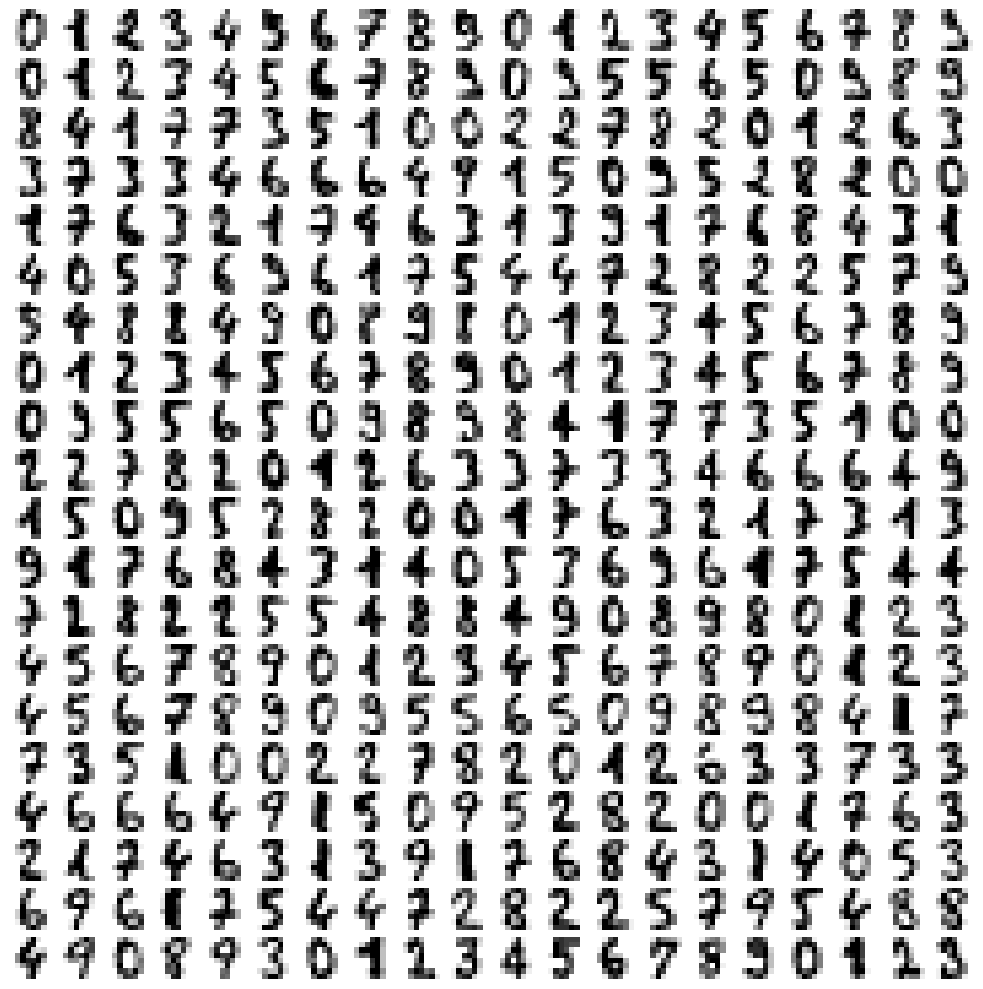

In [2]:
#### Visualize Raw Images

# Visualize a sample of the handwritten digits
fig, ax_array = plt.subplots(20, 20, figsize=(10, 10))
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.savefig('digits_sample.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Two-dimensional embeddings using PCA
# PCA will center the data by default
pca = PCA(n_components=2)
pca.fit(digits.data)

# Check explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}") #eigenvalues
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Explained variance ratio: [0.14890594 0.13618771]
Total variance explained: 0.2851


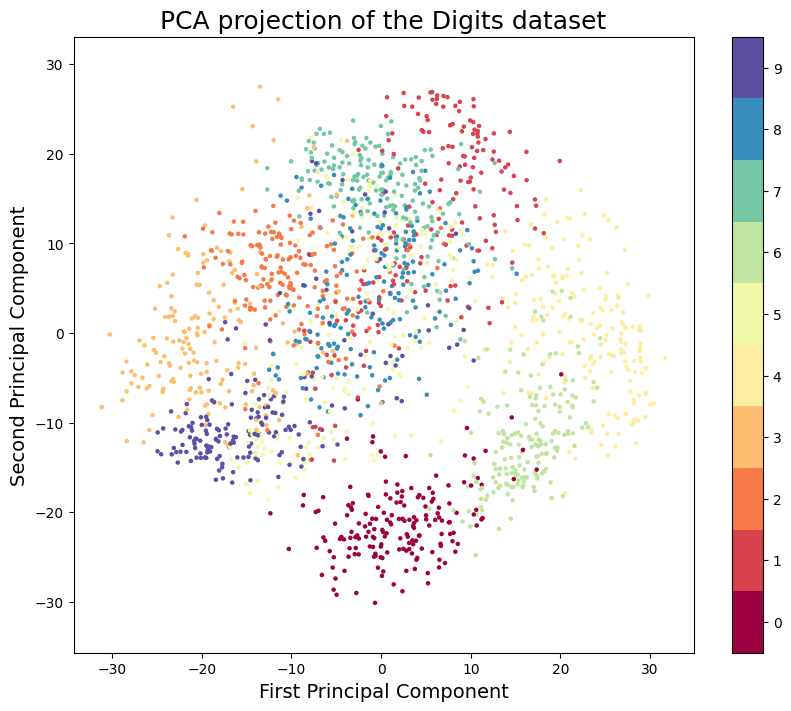

In [4]:
# Transform data to 2D
embedding_pca = pca.transform(digits.data)

# Visualize PCA embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], 
            c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('PCA projection of the Digits dataset', fontsize=18)
plt.xlabel('First Principal Component', fontsize=14)
plt.ylabel('Second Principal Component', fontsize=14)
plt.savefig('digits_pca.png', dpi=150, bbox_inches='tight')
plt.show()

PCA Struggles in data like handwritten digits because:

- The manifold of digit variations is nonlinear. 
- Handwritten digits don't vary in a linear way. For example of nonlinear changes: rotating a "6", stretching a "2", changing stroke thickness, etc. -> These transformations move the image through curved trajectories in high-demnsional pixel space (manifold), not straight lines.
- But PCA only captures global linear structure, not local curved structure. PCA finds directions (PCs) that maximize global varianace, cannot: preserve local structure, separate classes if they lie on intertwined nonlinear shapes, or simply follow curved manifolds.
(Digit datasets often have clusters that are locally meaningful (e.g., different styles of “1”) but globally hard to separate linearly.)

TAKEAWAY: there are focus on either local geometry or global geometry. PCA only cares about global geometry, which fails on handwritten digits. While UMAP cares about local geometry and compare different types of "local geometry", which works on handwritten digits.

In [21]:
import umap
import warnings
warnings.filterwarnings('ignore', message='n_jobs value')

# Create UMAP reducer with default parameters
reducer = umap.UMAP(
    n_neighbors=50,      # Size of local neighborhood (larger captures more global structure)
    min_dist=0.0,        # Minimum distance between points in embedding
    n_components=2,      # Dimensionality of embedding
    metric='euclidean',  # Distance metric
    random_state=42      # For reproducibility
)

# Fit the model and transform the data
reducer.fit(digits.data)

,n_neighbors,50
,n_components,2
,metric,'euclidean'
,metric_kwds,None
,output_metric,'euclidean'
,output_metric_kwds,None
,n_epochs,None
,learning_rate,1.0
,init,'spectral'
,min_dist,0.0
,spread,1.0


In [22]:
# Get the low-dimensional embedding
embedding_umap = reducer.transform(digits.data)

# Note: Can also access via reducer.embedding_
assert(np.all(embedding_umap == reducer.embedding_))

print(f'Dimensionality of the embedding: {embedding_umap.shape}')
print(f'Embedding bounds: x ∈ [{embedding_umap[:, 0].min():.2f}, {embedding_umap[:, 0].max():.2f}], '
      f'y ∈ [{embedding_umap[:, 1].min():.2f}, {embedding_umap[:, 1].max():.2f}]')

Dimensionality of the embedding: (1797, 2)
Embedding bounds: x ∈ [-5.53, 14.66], y ∈ [-14.07, 2.83]


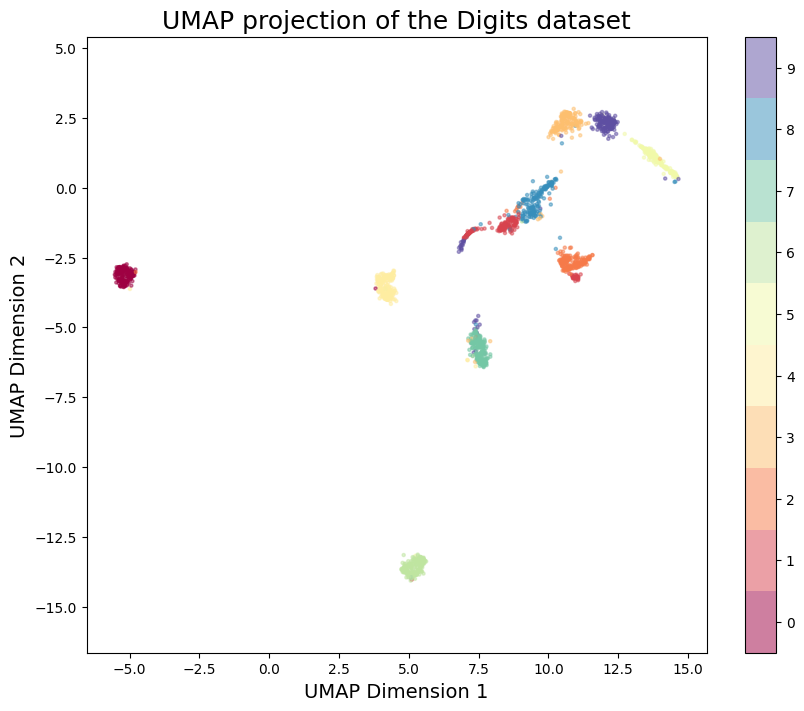

In [24]:
#### Visualize UMAP Embedding
### Dimensionality of the embedding: (1797, 2)
### Embedding bounds: x ∈ [-5.53, 14.66], y ∈ [-14.07, 2.83]

### n_neighbors = 50, min_dist = 0.0
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], 
                      c=digits.target, cmap='Spectral', s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(scatter, boundaries=np.arange(11)-0.5, ticks=np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.savefig('digits_umap.png', dpi=150, bbox_inches='tight')
plt.show()

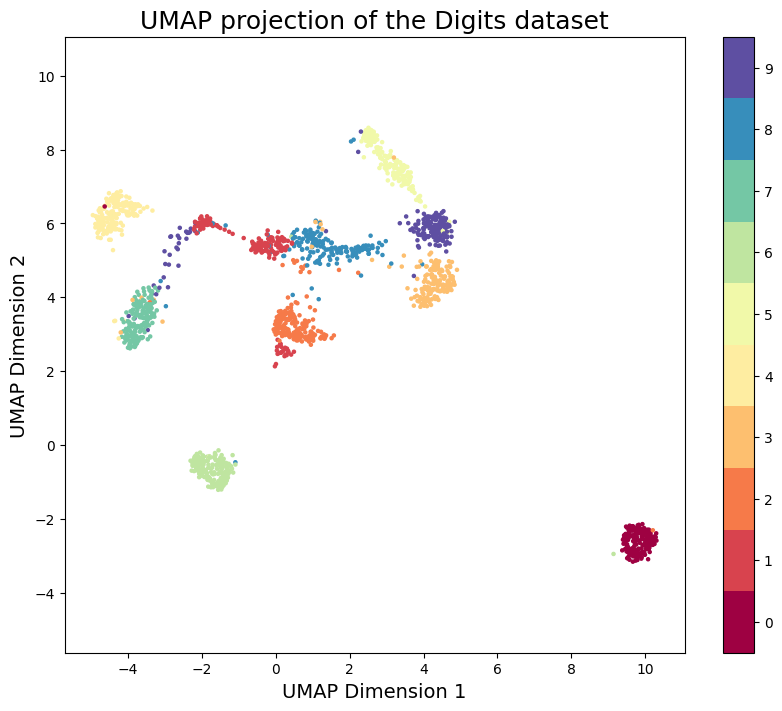

In [ ]:
#### Visualize UMAP Embedding
### Dimensionality of the embedding: (1797, 2)
### Embedding bounds: x ∈ [-4.96, 10.31], y ∈ [-3.16, 8.59]

### n_neighbors = 50, min_dist = 0.1
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], 
                      c=digits.target, cmap='Spectral', s=5, alpha=1.0)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(scatter, boundaries=np.arange(11)-0.5, ticks=np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.savefig('digits_umap.png', dpi=150, bbox_inches='tight')
plt.show()

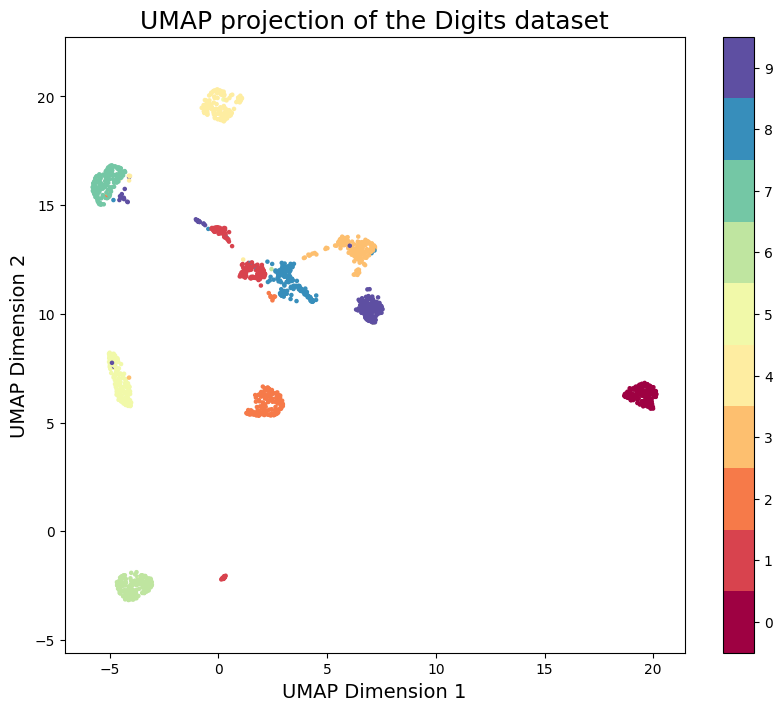

In [ ]:
#### Visualize UMAP Embedding
### Dimensionality of the embedding: (1797, 2)
### Embedding bounds: x ∈ [-5.77, 20.15], y ∈ [-3.16, 20.32]

### n_neighbors = 15, min_dist = 0.1
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], 
                      c=digits.target, cmap='Spectral', s=5, alpha=1.0)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(scatter, boundaries=np.arange(11)-0.5, ticks=np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.savefig('digits_umap.png', dpi=150, bbox_inches='tight')
plt.show()

### Advanced Topics and Extensions
#### Hyperparameter Tuning
n_neighbors: Control balance between local and global structure (default: 15)
- smaller values: more local structure, tighter and more fragmented clusters (5)
- larger values: more global structure, looser and more connected clusters (50)

min_dist: controls compactness of embedding (default: 0.1)
- smaller values: very tight clusters (0.0)
- biegger values: more spread out (0.5)

*Recomended Practice: 
- Start with default values (n_neighbors=15, min_dist=0.1)
- Adjust based on visual inspection and downstream task performance
- Use cross-validatin if using UMAP for preprocessing

#### Alternative Distance Metrics
consine: good for text, normalized features
correlation: good for time series
manhattan: L1 distance
hamming: ofr binary features

#### Supervised and Semi-supervised UMAP
#### Using UMAP for Preprocessing

### Limitations:
1. Doesn't preserve distsances: only preserves topology and local struture; don't interpret distance between clustesrs as similarity
2. Hyperparameter sensitivity
3. Non-deterministic
4. Computational cost: still expensive for very large datasets (> 1M points) -> Use subsampling or hierarchical approaches
5. Intepretation difficulty: embedding dimensions have no interpretable meaning (Unlike PCE components, UMAP dimensions are abstract)
6. Potential for over-interpretation: visual clusters might not reflect true statistical clusters -> always validate findings with other methods.

### Summray
1. Manifolds capture intrinsic structure: high-dimensional data often lies on low-dimensional manifolds
2. Graph-based representation: Manifold methods construct neighborbhood graphs to capture local geometry
3. UMAP advantages:
    - Preserves both local and global structure
    - Scalable to large datasets
    - Theoretically grounded
    - SOTA for visualization and preprocessing
4. Complementary to PCA
5. Pratical tool: UMAP is now a standard tool in data science for:
    - Understanding high-dimensional datasets
    - Quality control in single-cell genomics
    - Exploring learned representations in deep learning
    - Feature engineering
